In [ ]:
from google.colab import drive
drive.mount('/content/drive')#, force_remount=True)

Mounted at /content/drive


In [ ]:
!tar -xzf 'drive/MyDrive/Colab Notebooks/data/dichalcogenides_private.tar.gz'
!tar -xzf 'drive/MyDrive/Colab Notebooks/data/dichalcogenides_public.tar.gz'

In [ ]:
!pip install pymatgen
!pip install megnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yaml
import json

import pandas as pd
import numpy as np
import tensorflow as tf

from pathlib import Path
from pymatgen.core import Structure
from sklearn.model_selection import train_test_split
from megnet.models import MEGNetModel
from megnet.data.crystal import CrystalGraph

In [ ]:
def read_pymatgen_dict(file):
    with open(file, "r") as f:
        d = json.load(f)
    return Structure.from_dict(d)

In [ ]:
def energy_within_threshold(prediction, target):
    e_thresh = 0.02
    error_energy = tf.math.abs(target - prediction)

    success = tf.math.count_nonzero(error_energy < e_thresh)
    total = tf.size(target)
    return success / tf.cast(total, tf.int64)

In [ ]:
def prepare_dataset(dataset_path):
    dataset_path = Path(dataset_path)
    targets = pd.read_csv(dataset_path / "targets.csv", index_col=0)
    struct = {
        item.name.strip(".json"): read_pymatgen_dict(item)
        for item in (dataset_path / "structures").iterdir()
    }

    data = pd.DataFrame(columns=["structures"], index=struct.keys())
    data = data.assign(structures=struct.values(), targets=targets)

    return train_test_split(data, test_size=0.25, random_state=666)

In [ ]:
def prepare_model(cutoff, lr):
    nfeat_bond = 10
    r_cutoff = cutoff
    gaussian_centers = np.linspace(0, r_cutoff + 1, nfeat_bond)
    gaussian_width = 0.8
    
    return MEGNetModel(
        graph_converter=CrystalGraph(cutoff=r_cutoff),
        centers=gaussian_centers,
        width=gaussian_width,
        loss=["MAE"],
        npass=2,
        lr=lr,
        metrics=energy_within_threshold
    )

In [ ]:
with open("drive/MyDrive/Colab Notebooks/data/config.yaml") as file:
        config = yaml.safe_load(file)

train, test = prepare_dataset(config["datapath"])
model = prepare_model(
    float(config["model"]["cutoff"]),
    float(config["model"]["lr"]), 
)
history = model.train(
    train.structures,
    train.targets,
    validation_structures=test.structures,
    validation_targets=test.targets,
    epochs=int(config["model"]["epochs"]),
    batch_size=int(config["model"]["batch_size"]),
)

Epoch 1/300
35/35 [==============================] - 50s 1s/step - loss: 0.6737 - energy_within_threshold: 0.0170
Epoch 2/300
35/35 [==============================] - 28s 796ms/step - loss: 0.4624 - energy_within_threshold: 0.0013
Epoch 3/300
35/35 [==============================] - 28s 796ms/step - loss: 0.4609 - energy_within_threshold: 0.0000e+00
Epoch 4/300
35/35 [==============================] - 28s 800ms/step - loss: 0.4609 - energy_within_threshold: 4.4643e-04
Epoch 5/300
35/35 [==============================] - 27s 793ms/step - loss: 0.4630 - energy_within_threshold: 5.9524e-04
Epoch 6/300
35/35 [==============================] - 28s 791ms/step - loss: 0.4613 - energy_within_threshold: 0.0000e+00
Epoch 7/300
35/35 [==============================] - 29s 844ms/step - loss: 0.4600 - energy_within_threshold: 4.4643e-04
Epoch 8/300
35/35 [==============================] - 28s 788ms/step - loss: 0.4615 - energy_within_threshold: 8.9286e-04
Epoch 9/300
35/35 [========================

In [ ]:
import json
with open("drive/MyDrive/Colab Notebooks/data/data.json", 'r') as f:
  data = json.load(f)

Text(0.5, 1.0, 'loss')

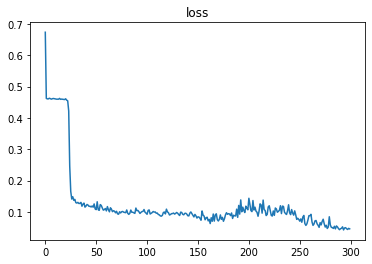

In [ ]:
import matplotlib.pyplot as plt
plt.plot(data[0])
plt.title("loss")

Text(0.5, 1.0, 'energy_within_threshold')

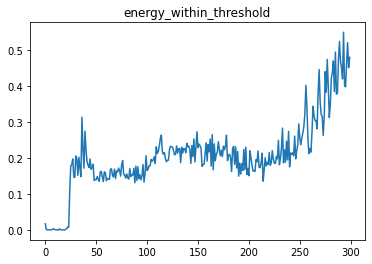

In [ ]:
plt.plot(data[1])
plt.title("energy_within_threshold")